# MIMIC-III Sepsis Feature Probe

There are many possible features and markers that could indicate the survivability of a patient with suspected sepsis. In this notebook I will probe and visualize the suspected features of import. I will conduct several techniques to select features and trim less significant ones using univariate analysis and other techniques.

Note that the dataset in its entirety has been set up locally on a Postgresql database. All machine learning will be done remotely to save time and resources down the road.

In [415]:
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
from sklearn import preprocessing

import matplotlib.pyplot as plt
import datetime

import seaborn as sns
sns.set(style='ticks')

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import pymssql
import pandas as pd

conn=pymssql.connect(host='192.168.60.28', user='mimic', password='asx^&34513', port=1433, database='mimic',
                           charset='utf8')


from sqlalchemy import create_engine,Column,Integer,String,Float,func
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
from random import randint



In [416]:
data=pd.read_sql("Select * from [mimiciii.admissions] where diagnosis='SEPSIS' ",conn)

In [244]:
#admission_query = session.query(Admission).filter_by(diagnosis='SEPSIS')

#df = pd.read_sql(admission_query.statement, admission_query.session.bind)

In [417]:
def period(row, period):
    
    if row['deathtime'] == None:
        return 0
    elif row['deathtime'] - row['admittime'] > period:
        return 0
    else:
        return 1  #dead in a short time
    row['admittime']

In [418]:
data['death_period'] = data.apply (lambda row: period (row, pd.Timedelta('30 days')),axis=1)


In [419]:
adm_col = ['subject_id', 'hadm_id', 'admittime', 'admission_type', 'insurance', 'ethnicity', 'death_period']
admissions = data[adm_col]

In [420]:
# Obtain patient information and trim unnecessary information
#patient_query = session.query(Patient)
patients=pd.read_sql("Select * from [mimiciii.patients]",conn)
#patients = pd.read_sql(patient_query.statement, patient_query.session.bind)
patients = patients[['subject_id', 'gender', 'dob']]


In [421]:
# Join patients and admission dataframes to obtain gender and age of patient
patient_info = admissions.join(patients.set_index('subject_id'), on='subject_id')
#patient_info = pd.read_sql("select  [mimiciii.patients].subject_id,gender,dob,hadm_id, admittime, admission_type, insurance, ethnicity from [mimiciii.patients] join [mimiciii.admissions] on [mimiciii.patients].subject_id=[mimiciii.admissions].subject_id where [mimiciii.admissions].diagnosis='SEPSIS'",conn)
patient_info.head()

,subject_id,hadm_id,admittime,admission_type,insurance,ethnicity,death_period,gender,dob
0,357,122609,2198-11-01 22:36:00,EMERGENCY,Private,WHITE,1,M,2135-03-22
1,366,134462,2164-11-18 20:27:00,EMERGENCY,Medicare,HISPANIC OR LATINO,1,M,2112-05-22
2,94,183686,2176-02-25 16:49:00,EMERGENCY,Medicare,ASIAN,1,M,2101-09-20
3,21,111970,2135-01-30 20:50:00,EMERGENCY,Medicare,WHITE,1,M,2047-04-04
4,353,108923,2151-03-28 16:01:00,EMERGENCY,Medicare,WHITE,1,M,2089-07-23


Age must be calculated from two different tables. The admissions table for date of admission and the patient table for date of birth. Age may play a significant role in the survivability.

In [422]:
import time
def age(row):
    possible_age = pd.Timestamp(row['admittime'],unit='ms') - pd.Timestamp(row['dob'],unit='ms')#/pd.Timedelta('365 days',unit='ms'))
    
    # For those holder than 89, their ages have been removed and set to 300 years prior to admission.     
    #if possible_age < 0:
        # 91.4 is the median age for those with removed ages. This is what we will set all ages to that are older than 89       
     #   possible_age = 91
    return possible_age


In [423]:
patient_info['age'] = patient_info.apply (lambda row:  round(int(str(age(row)).split(' ')[0])/365),axis=1)


In [424]:
for i in range(1184):
     if patient_info['age'][i]>89:
        patient_info['age'][i]=91

## Analyzing the Importance of Basic Patient Information

The admission table has been trimmed and a period of importance for mortality computed. The patient information table has been trimmed and joined to the modified admission table. It is now possible to look into several different potentially useful details regarding patient mortality.

In [425]:
patient_info.describe()

,subject_id,hadm_id,death_period,age
count,1184.000000,1184.000000,1184.000000,1184.00000
mean,32912.771115,149545.354730,0.987331,67.03125
std,28172.426424,29131.331324,0.111888,16.47960
min,21.000000,100262.000000,0.000000,0.00000
25%,10827.500000,123816.000000,1.000000,56.00000
50%,23820.500000,149640.500000,1.000000,68.50000
75%,50275.500000,175462.000000,1.000000,80.00000
max,99973.000000,199880.000000,1.000000,91.00000


In [426]:
pos = patient_info[patient_info['death_period'] == 0]
neg = patient_info[patient_info['death_period'] == 1]
print (pos.shape)
print (neg.shape)

(15, 10)
(1169, 10)


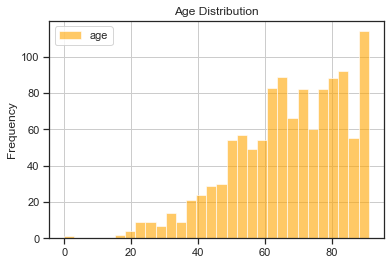

In [427]:
ax = patient_info[['age']].plot(kind='hist', title ="Age Distribution", legend=True, grid=True, bins=30, color='orange', alpha=0.6)

### Data Overview
A trend can be seen in the age of patients admitted with suspected sepsis. As age increases, the risk of sepsis also increases somewhat linearly. It is important to note that the large number of patients at 92 years old is due to a HIPAA compliency that removes exact ages of those older than 89. The median value is approximately 92 years of age, hence the large number in that bucket.

The mean age is ~67 years old with a standard deviation of ~17 years. This is another clear indication that sepsis is particularly relevant to those older than 56 years of age. 75% of the cases affect patients older than 56 years old.

#### Mortality 
There are a total of 1184 patients admitted with suspected sepsis. Of those admitted, 932 survived >30 days in the ICU. 256 did not survive 30 days after admittance. Therefore there is a 21% mortality rate of those admitted with suspected sepsis. Next let us break this down by age.

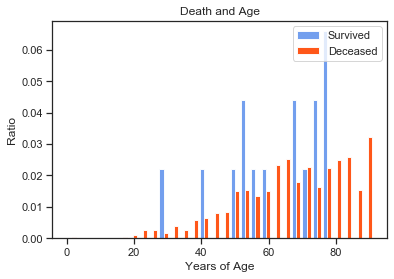

In [428]:
_ = plt.hist([pos['age'],neg['age']], bins=30, alpha=0.9, normed=True, label=['Survived','Deceased'], color=['cornflowerblue','orangered'])

plt.title('Death and Age')
plt.xlabel('Years of Age')
plt.ylabel('Ratio')
plt.legend(loc='upper right')

#### Age and Survivability
While there is no clear marker, around 50 years of age a switch from primarily surviving a septic condition with a probability >0.75 to primarily succuming to the condition. This, visually, suggests that age is particularly important in the survivaibility. There are likely other factors that are strongly correlated to age however.

### Gender and Survivability

Male Mortality: 79.625
Female Mortality: 76.0


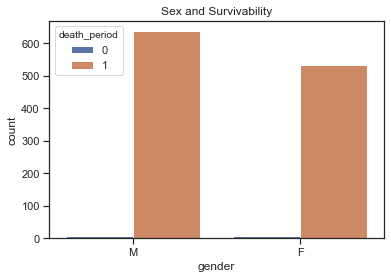

In [429]:
ax = plt.axes()
sns.countplot(x="gender", hue="death_period", data=patient_info, ax=ax)
ax.set_title('Sex and Survivability')
alive = pos.gender.value_counts()
dead = neg.gender.value_counts()
print("Male Mortality: {}".format(dead.M/float(alive.M)))
print ("Female Mortality: {}".format(dead.F/float(alive.F)))

Gender does not appear to play a significant role on the survivability of sepsis, however, in conjunction with another feature it may add useful information. Male respitory rate may be lower than female respitory rate and may help shift the importance in a machine learning algorithm.

### Insurance Type and Survivability

Medicare Mortality: 100.75
Medicaid Mortality: 30.333333333333332
Private Mortality: 82.0


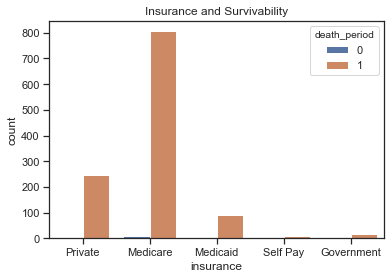

In [430]:
ax = plt.axes()
sns.countplot(x="insurance", hue="death_period", data=patient_info, ax=ax)
ax.set_title('Insurance and Survivability')

alive = pos.insurance.value_counts()
dead = neg.insurance.value_counts()
print ("Medicare Mortality: {}".format(dead.Medicare/float(alive.Medicare)))
print ("Medicaid Mortality: {}".format(dead.Medicaid/float(alive.Medicaid)))
print ("Private Mortality: {}".format(dead.Private/float(alive.Private)))


This breakdown of survivability by insurance type makes sense. Medicare is insurance administered by the US Government and fulfilled by private insurers for individuals 65 years and older. From the previous breakdown by age, we can see that those older than 65 are at an increased risk of succumbing to sepsis. Private insurance holders are likely younger. Therefore the descrepency in survivability is more understandable, 30% mortality rate for Medicare insurance holders and almost half that for private insurance holders at 17%.

The real question comes when we look at Medicaid mortality rates which are 27%. Medicaid is provided by the US Government to individuals that reside at or at 133% of the poverty line. What this is indicating is that income also plays a role on the survivability of a septic condition.

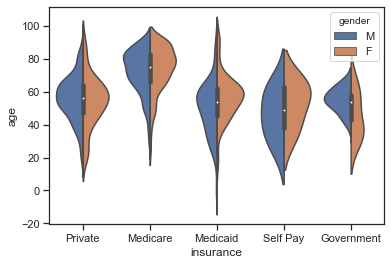

In [431]:
sns.violinplot(x="insurance", y="age", hue="gender", data=patient_info, split=True);

Here we can see a violin graph with age on the y-axis, insurance type on the x-axis, and Male represented by blue and Female by green. This clariefies the suspicion that Medicare holders are older on average. Medicaid and Private insurance holders appear to be approximately the same age on average. Self pay and government insurance have too few data points to draw any sort of conclusion. Gender also seems relatively balanced except for Medicaid insurance holders. More young men tend to have medicaid insurance than young women.

## Obtaining Vitals

The initial vitals, within 48 hours, will likely be the most useful information for predicting the survivability of a septic condition. Graphing and visualizing this data will allow us to make insights into which features are of higher importance and which are likely irrelevant and can be trimmed from the dataset.

In [432]:
vital_ids = {   
                50827: 'respiration', # respiration rate
                50912: 'creatinine',  # creatinine levels indicate kidney issues
                50813: 'lactate',     # lactate levels indicate shock and cellular anirobic respiration
                50889: 'CRP',         # C-reactive protein systemic inflammation
                51300: 'WBC',         # White blood cell count indicates systemic reaction to infection
                51006: 'BUN',         # Blood Urea Nitrogen indicates kidney issues
                51288: 'ESR',         # erythrocyte sedimentation rate another inflammation test
                51265: 'platelet',    # decreased platelet counts parallel the severity of infection
                50825: 'tempurature', # tempurature is highly indicative of infection and/or immune response
                50816: 'oxygen',
                51275: 'PT',
                51274: 'PTT',
                51277: 'RBCDW',       # red blood cell distribution width
                51256: 'neutrophils',
                50818: 'pco2',
                50821: 'po2',
                50893: 'calcium',
                50931: 'glucose',
                51221: 'hematocrit',
                51222: 'hemoglobin',
                51244: 'lymphocytes',
                
                51248: 'MCH',
                51237: 'INR',
                50956: 'lipase',
                50878: 'AST',
                50867: 'amylase',
                50863: 'alkaline phosphatase',
                50820: 'PH',
                50882: 'bicarbonate'
            } 

In [433]:
# Query database labevents for all information related to all hospital admission ids we are interested in 
# along with all item types we are interested in, defined above
patient_hadm_ids = patient_info.hadm_id.tolist()
lab_events=pd.read_sql_query("Select * from [mimiciii.Labevents] where (hadm_id in (select hadm_id from [mimiciii.admissions] join [mimiciii.patients] on [mimiciii.admissions].subject_id=[mimiciii.patients].subject_id) and  [mimiciii.Labevents].itemid in (50827,50912,50813,50889,51300,51006,51288,51265,50825,50816,51275,51274,51277,51256,50818,50821,50893,50931,51221,51222,51244,51248,51237,50956,50878,50867,50863,50820,50882))",conn)
# Beautiful query /sarcasm

#lab_event_query = session.query(LabEvent).filter(LabEvent.hadm_id.in_(patient_hadm_ids)).filter(LabEvent.itemid.in_(vital_ids.keys()))

lab_events=lab_events.groupby('hadm_id')
#lab_events = pd.read_sql("Select * from [mimiciii.labevents]",conn)

In [434]:
patient_info['admittime'].values[0]

numpy.datetime64('2198-11-01T22:36:00.000000000')

In [435]:
# Prepare joining copy of patient vitals
patient_vitals = patient_info[['hadm_id']].copy()
for value in vital_ids.values():
    patient_vitals[value] = np.nan
    
patient_vitals = patient_vitals.set_index('hadm_id')

In [436]:
# Respiration rate value needs to be cleaned. 
def clean_respiration(value):
    return max([int(x) for x in value.split('/') if x.isdigit()])

In [437]:
# Cycle through data, check for appropriate data within time period, average values and store
one_day = pd.Timedelta('1 days')
# Each hospital stay, think of it as an individual patient (though technically not true)
for hadm_id, group in lab_events:
    sub_groups = group.groupby('itemid')
    if len(patient_info.loc[patient_info.hadm_id==hadm_id]['admittime'].values)!=0:
        admittance_time = patient_info.loc[patient_info.hadm_id==hadm_id]['admittime'].values[0]
    else:
        admittance_time=np.datetime64('2100-01-01T00:00:00.000000000')
    # Each lab item type
    for lab_item, sub_group in sub_groups:
        if admittance_time!=[]:
            day_results = sub_group[((sub_group.charttime - admittance_time) < one_day)]
        # Unfortunate special case: If dirty respitory rate value, clean         
            if lab_item == 50827:
                cleaned_resp = list(map(clean_respiration, day_results['value']))
                mean =  np.mean(cleaned_resp)
            else:
                mean = day_results['valuenum'].values.mean()
            patient_vitals.set_value(hadm_id, vital_ids[lab_item], mean)
    

In [438]:
patient_vitals.head()

,respiration,creatinine,lactate,CRP,WBC,BUN,ESR,platelet,tempurature,oxygen,...,hemoglobin,lymphocytes,MCH,INR,lipase,AST,amylase,alkaline phosphatase,PH,bicarbonate
hadm_id,,,,,,,,,,,,,,,,,,,,,
122609,NaN,1.220000,1.50,NaN,NaN,56.200000,NaN,82.750000,NaN,NaN,...,8.475000,15.466667,34.25,1.366667,62.0,96.333333,47.0,140.666667,NaN,16.400000
134462,NaN,1.466667,3.55,224.1,NaN,16.000000,51.0,199.000000,NaN,NaN,...,14.350000,1.500000,35.85,1.150000,19.0,56.500000,90.0,90.000000,NaN,25.000000
183686,12.0,0.700000,1.80,6.4,NaN,8.666667,NaN,155.666667,38.4,57.5,...,14.033333,8.900000,35.30,1.000000,27.5,82.333333,46.0,68.666667,7.375,23.250000
111970,NaN,4.200000,1.60,NaN,NaN,49.500000,NaN,353.500000,NaN,NaN,...,9.200000,3.950000,29.90,1.750000,16.0,82.000000,25.0,167.000000,NaN,23.500000
108923,NaN,7.000000,3.05,NaN,NaN,63.500000,NaN,152.500000,NaN,NaN,...,10.600000,4.100000,34.75,1.300000,NaN,32.000000,NaN,44.000000,NaN,28.333333


In [439]:
# Check which features are not worth considering due to lack of information
patient_vitals.isnull().sum()

respiration             57082
creatinine              56139
lactate                 56217
CRP                     57124
WBC                     57303
BUN                     56139
ESR                     57251
platelet                56139
tempurature             56765
oxygen                  56967
PT                      56203
PTT                     56199
RBCDW                   56141
neutrophils             56189
pco2                    56543
po2                     56543
calcium                 56154
glucose                 56140
hematocrit              56140
hemoglobin              56141
lymphocytes             56189
MCH                     56142
INR                     56199
lipase                  56567
AST                     56314
amylase                 56758
alkaline phosphatase    56329
PH                      56486
bicarbonate             56145
dtype: int64

I made the near-sighted assumption that most patients would have these vitals taken within the first day. It is possible some of these measurements, such as temperature, are recorded elsewhere in the database. For data within the lab events table, though, I will need to trim some of this data due to the lack of values. The few instances with no information will be filled in with the mean values. For the ML phase, I may need to trim some patients out that have no recorded values or died within the first day of entering the ICU.

In [440]:
# Vitals that will be kept. The rest dropped due to lack of data
keep_vitals = ['bicarbonate' ,'INR' ,'MCH' ,'AST', 'alkaline phosphatase' ,'PH', 'creatinine', 'platelet', 'PT', 'PTT', 'lymphocytes', 'RBCDW', 'calcium', 'neutrophils', 'glucose', 'hematocrit', 'hemoglobin', 'lactate', 'BUN']
patient_vitals_fixed = patient_vitals[keep_vitals]

In [441]:
# Replace NaN values with the mean of each column. In the actual ML phase it may be worth figuring out WHY
# Some values are missing. Here we will simply continue with mean.
patient_vitals_fixed = patient_vitals_fixed.fillna(patient_vitals.mean())

In [442]:
# Add age column prior to standardization
keep_vitals.append('age')

In [443]:
patient_vitals_fixed.head()

,bicarbonate,INR,MCH,AST,alkaline phosphatase,PH,creatinine,platelet,PT,PTT,lymphocytes,RBCDW,calcium,neutrophils,glucose,hematocrit,hemoglobin,lactate,BUN
hadm_id,,,,,,,,,,,,,,,,,,,
122609,16.400000,1.366667,34.25,96.333333,140.666667,7.329011,1.220000,82.750000,29.233333,15.466667,15.466667,15.250000,7.260000,77.133333,179.800000,26.675000,8.475000,1.50,56.200000
134462,25.000000,1.150000,35.85,56.500000,90.000000,7.329011,1.466667,199.000000,29.150000,13.300000,1.500000,16.350000,7.900000,86.500000,154.000000,41.600000,14.350000,3.55,16.000000
183686,23.250000,1.000000,35.30,82.333333,68.666667,7.375000,0.700000,155.666667,31.000000,12.000000,8.900000,13.733333,8.075000,83.700000,158.250000,39.925000,14.033333,1.80,8.666667
111970,23.500000,1.750000,29.90,82.000000,167.000000,7.329011,4.200000,353.500000,37.600000,18.600000,3.950000,17.300000,7.700000,91.250000,189.000000,30.100000,9.200000,1.60,49.500000
108923,28.333333,1.300000,34.75,32.000000,44.000000,7.329011,7.000000,152.500000,24.650000,14.100000,4.100000,16.150000,8.766667,93.500000,98.666667,30.733333,10.600000,3.05,63.500000


In [444]:
# New patient info dataframe finally with vitals
vital_patient_info = patient_info.join(patient_vitals_fixed, on='hadm_id')

In [445]:
# Standardize the data from vital columns
stdsc = preprocessing.StandardScaler()
vital_patient_info[keep_vitals] = stdsc.fit_transform(vital_patient_info[keep_vitals])

In [446]:
# New pos and neg df for easy consideration of survival
pos = vital_patient_info[vital_patient_info['death_period'] == 0]
neg = vital_patient_info[vital_patient_info['death_period'] == 1]

--------------------------------------------------------------------------------------------------------------------------------------------

## Visualize Patient Vitals

Now that we have gathered feasible patient vitals and it will be useful to see the distribution of such information and if there is any visual correlation between 30 day mortality and initial readings.



In [336]:
vital_columns = keep_vitals[:]
vital_columns.extend(['death_period'])

In [337]:
vitals_only = vital_patient_info[vital_columns]

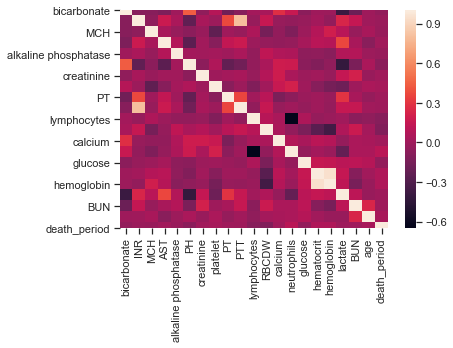

In [338]:
# Observe correlation of values
correlation_df = vitals_only.corr().copy()
sns.heatmap(correlation_df)

While this doesn't throw any obvious red flags in correlation, it is important to note that this is thousands of human bodies and results are varied with many factors playing a role. There are several interesting correlations that are unrelated to mortality. Lymphocytes and neutrophils are quite strongly negatively correlated with these tests. PT and PTT are relatively strongly correlated, which makes sense since they are both clotting factor tests. Hematocrit and hemoglobin are very strongly correlated which also makes sense. Hematocrit tests for "the ratio of the volume of red blood cells to the total volume of blood", while hemoglobin tests for "a red protein responsible for transporting oxygen in the blood of vertebrates".

Next, we will just observe the mortality rate and associated correlations.

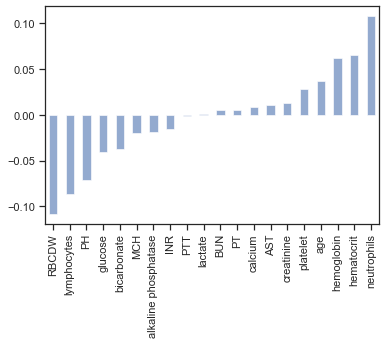

In [339]:
tst = correlation_df['death_period']
tst = tst.drop('death_period')
tst.sort_values(inplace=True)
tst.plot(kind='bar', alpha=0.6)

A very interesting view of correlation to mortality can be seen here. From my previous study, platelet count, glucose levels, and creatinine are strongly correlated with the survivability of a septic condition. Here we can see, that isn't necessarily true. Lactate levels, as suspected, are strongly correlated, however. Why is this? Lactate levels in the blood indicate anaerobic cellular respiration this means that cells are producing lactic acid instead of respiring normally, producing CO2. The production of lactic acid means cells are not receiving oxygen, a sign of septic shock. This is promising. While BUN is not highly correlated with mortality, it is somewhat useful. BUN indicates blood urea nitrogen levels. This is an indication that the kidneys are not properly filtering urea from the blood. This is a good indication of organ dysfunction.

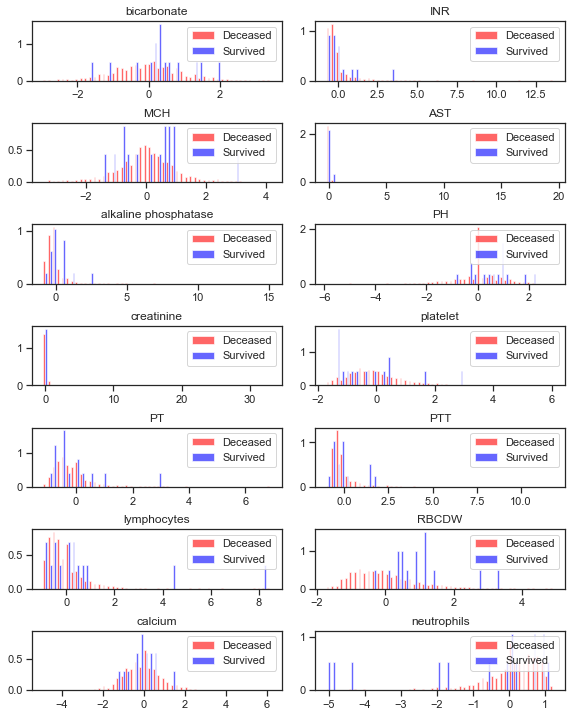

In [340]:
vital_columns_cp = vital_columns[:]
vital_columns_cp.remove('death_period')

plt.rcParams.update({'font.size': 8})
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(8,10))
axes = axes.ravel()
for idx,axis in enumerate(axes):
    axis.figure
    
    binwidth= (max(vitals_only[vital_columns_cp[idx]]) - min(vitals_only[vital_columns_cp[idx]]))/50
    bins = 50
    axis.hist([neg[vital_columns_cp[idx]],pos[vital_columns_cp[idx]]], bins=bins, alpha=0.6, normed=True, label=['Deceased','Survived'], color=['red','blue'])
    axis.legend(loc='upper right')
    axis.set_title(vital_columns_cp[idx])
plt.tight_layout()

Again, nothing jumps out as a red flag clearly indicating survivability here, but there are some useful trends within each feature. There appears to be a slight indication of mortality with low platelet counts. The extended positive tail associated with mortality on PT, PTT, RBCDW, lactate, and BUN are useful. The negative increasing tail associated with mortality in neutrophils is also a useful feature.

While I would have been happy seeing several strongly correlated features, this is promising information. Next, let us conduct principal component analysis to further look at how features interact.

## Principal Component Analysis


In [341]:
from sklearn.decomposition import PCA

def pca_explain(observables, components=3):
    pca = PCA(n_components=components)
    pca.fit(observables)

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # Individual PCA Components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = observables.keys())
    components.index = dimensions

    # Explained variance in PCA
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    print(pd.concat([variance_ratios, components], axis = 1))

In [342]:
observables = vitals_only
observables = observables.drop('death_period', 1)

In [343]:
pca_explain(observables, 5)

             Explained Variance  bicarbonate     INR     MCH     AST  \
Dimension 1              0.1436      -0.3203  0.3732  0.0843  0.2736   
Dimension 2              0.1202       0.0198  0.2107 -0.2133 -0.0586   
Dimension 3              0.0930      -0.1392 -0.2436  0.1431 -0.0595   
Dimension 4              0.0738       0.4222  0.3515 -0.0593 -0.0354   
Dimension 5              0.0711       0.1026 -0.0400 -0.0432 -0.0458   

             alkaline phosphatase      PH  creatinine  platelet      PT  ...  \
Dimension 1                0.0280 -0.3822      0.0750   -0.1569  0.3293  ...   
Dimension 2                0.1196  0.0492      0.0623    0.1570  0.1110  ...   
Dimension 3               -0.0765 -0.0772     -0.1122   -0.2297 -0.0558  ...   
Dimension 4               -0.0314  0.2352     -0.1506   -0.0254  0.1583  ...   
Dimension 5                0.1154  0.0660      0.4115    0.0573 -0.1509  ...   

             lymphocytes   RBCDW  calcium  neutrophils  glucose  hematocrit  \
Dimensi

This PCA breakdown gives a good indication of how features are correlated and explain variance. It is important to note that the features that are involved in PCA must be standardized to obtain any useful results. In these five components only about 60% of variance is explained. This makes it more clear the features are not all strongly correlated and cannot easily be collapsed into fewer dimensions. It may be useful to remove features that clearly do not help explain the survivability of sepsis prior to utilizing dimensional reduction.

## Linear Discriminant Analysis

In [362]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def lda_explain(X, y):
    lda = LinearDiscriminantAnalysis(solver='eigen', shrinkage = 'auto')
    lda.fit(X, y)

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(X.columns)+1)]
    
    
    # Individual LDA Components
    components = pd.DataFrame(np.round(lda.covariance_, 4), columns = observables.keys())
    components.index = dimensions

    # Explained variance in LDA
    ratios = np.array(list(lda.explained_variance_ratio_)).reshape(len(X.columns), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    print(pd.concat([variance_ratios, components], axis = 1))

In [364]:
#lda_explain(observables, vitals_only['death_period'])
lda = LinearDiscriminantAnalysis(solver='eigen', shrinkage = 'auto')
lda.fit(observables, vitals_only['death_period'])
lda.explained_variance_ratio_


array([1.5370039])

## Microbiology Events
We have seen how some basic vitals play a role in correlation with mortality. It may be that certain types of infection also have a strong correlation to mortality as well. Here a 24 hour reading of infection will be obtained, with zero, one, or multiple types of infection. It will be encoded properly and visualized.

In [375]:
# Beautiful query /sarcasm
#bio_event_query = session.query(BioEvent).filter(BioEvent.hadm_id.in_(patient_hadm_ids)).filter(BioEvent.org_name != None)

# print bio_event_query
#bio_events = pd.read_sql(bio_event_query.statement, bio_event_query.session.bind)
bio_events=pd.read_sql_query("Select * from [mimiciii.microbiologyevents] where ([mimiciii.microbiologyevents].hadm_id in (select  hadm_id from [mimiciii.patients] join [mimiciii.admissions] on [mimiciii.patients].subject_id=[mimiciii.admissions].subject_id where [mimiciii.admissions].diagnosis='SEPSIS')) and  [mimiciii.microbiologyevents].org_name is not Null",conn)


bio_events=bio_events.groupby('hadm_id')


In [377]:
test_bio_events = pd.read_sql_query("Select * from [mimiciii.microbiologyevents] where ([mimiciii.microbiologyevents].hadm_id in (select  hadm_id from [mimiciii.patients] join [mimiciii.admissions] on [mimiciii.patients].subject_id=[mimiciii.admissions].subject_id where [mimiciii.admissions].diagnosis='SEPSIS')) and  [mimiciii.microbiologyevents].org_name is not Null",conn)
test_bio_events.head()

,row_id,subject_id,hadm_id,chartdate,charttime,spec_itemid,spec_type_desc,org_itemid,org_name,isolate_num,ab_itemid,ab_name,dilution_text,dilution_comparison,dilution_value,interpretation
0,29485,2322,106895,2177-09-29,2177-09-29 22:07:00,70023.0,CATHETER TIP-IV,80155.0,"STAPHYLOCOCCUS, COAGULASE NEGATIVE",1,90015.0,VANCOMYCIN,2,=,2.0,S
1,29486,2322,106895,2177-09-29,2177-09-29 22:07:00,70023.0,CATHETER TIP-IV,80155.0,"STAPHYLOCOCCUS, COAGULASE NEGATIVE",1,90027.0,RIFAMPIN,<=0.5,<=,1.0,S
2,29487,2322,106895,2177-09-29,2177-09-29 22:07:00,70023.0,CATHETER TIP-IV,80155.0,"STAPHYLOCOCCUS, COAGULASE NEGATIVE",1,90016.0,OXACILLIN,=>4,=>,4.0,R
3,29488,2322,106895,2177-09-29,2177-09-29 22:07:00,70023.0,CATHETER TIP-IV,80155.0,"STAPHYLOCOCCUS, COAGULASE NEGATIVE",1,90012.0,GENTAMICIN,=>16,=>,16.0,R
4,29489,2322,106895,2177-09-29,2177-09-29 22:07:00,70023.0,CATHETER TIP-IV,80155.0,"STAPHYLOCOCCUS, COAGULASE NEGATIVE",1,90011.0,TETRACYCLINE,=>16,=>,16.0,R


In [378]:
# Prepare joining copy of patient vitals
patient_bio = patient_info[['hadm_id']].copy()
patient_bio['infection'] = np.nan
patient_bio['num_infections'] = 0
patient_bio.infection = patient_bio.infection.astype(object)
    
patient_bio = patient_bio.set_index('hadm_id')

In [379]:
infection_types = set()

# Obtain each unique infection and throw into a set for multilabelbinerizer
for hadm_id, group in bio_events:
    admittance_time = patient_info.loc[patient_info.hadm_id==hadm_id]['admittime'].values[0]
    day_results = group[((group.charttime - admittance_time) < one_day)]
    infections = tuple(day_results.org_name.unique())
    infection_types.update(infections)

    patient_bio.set_value(hadm_id, 'infection', infections)
    patient_bio.set_value(hadm_id, 'num_infections', len(infections))

for row in patient_bio.loc[patient_bio.infection.isnull(), 'infection'].index:
    patient_bio.at[row, 'infection'] = tuple()
    

In [380]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
bio_matrix = mlb.fit_transform(patient_bio['infection'])

feature_df = pd.DataFrame(data=bio_matrix, columns=mlb.classes_,  index=patient_bio.index)
multi_bio = pd.concat([feature_df, patient_bio], axis=1)

In [381]:
patient_bio.loc[patient_bio.num_infections > 1]

,infection,num_infections
hadm_id,,
111970,"(ENTEROCOCCUS FAECIUM, CLOSTRIDIUM DIFFICILE)",2
148905,"(GRAM NEGATIVE ROD(S), GRAM NEGATIVE ROD #1)",2
113900,"(KLEBSIELLA PNEUMONIAE, ENTEROCOCCUS SP.)",2
171178,"(ENTEROBACTER CLOACAE, GRAM NEGATIVE ROD #2, G...",5
107880,"(ENTEROCOCCUS SP., YEAST, STAPH AUREUS COAG +)",3
108911,"(ESCHERICHIA COLI, GRAM NEGATIVE ROD(S))",2
170452,"(PREVOTELLA SPECIES, GRAM NEGATIVE ROD #2, STA...",6
103873,"(PROTEUS MIRABILIS, PROVIDENCIA STUARTII)",2
163526,"(ENTEROCOCCUS FAECALIS, STAPHYLOCOCCUS, COAGUL...",3


In [382]:
multi_bio = multi_bio.drop('infection', 1)

In [383]:
# New patient info dataframe finally with vitals
multi_bio = vital_patient_info.join(multi_bio, on='hadm_id')

pos = multi_bio[multi_bio['death_period'] == 0]
neg = multi_bio[multi_bio['death_period'] == 1]

In [384]:
multi_bio.head()

,subject_id,hadm_id,admittime,admission_type,insurance,ethnicity,death_period,gender,dob,age,...,STREPTOCOCCUS MILLERI GROUP,STREPTOCOCCUS PNEUMONIAE,STRONGYLOIDES STERCORALIS,VARICELLA-ZOSTER VIRUS,VIBRIO SPECIES,VIRIDANS STREPTOCOCCI,VIRUS,YEAST,"YEAST, PRESUMPTIVELY NOT C. ALBICANS",num_infections
0,357,122609,2198-11-01 22:36:00,EMERGENCY,Private,WHITE,1,M,2135-03-22,-0.184017,...,0,0,0,0,0,0,0,0,0,0
1,366,134462,2164-11-18 20:27:00,EMERGENCY,Medicare,HISPANIC OR LATINO,1,M,2112-05-22,-0.851791,...,0,0,0,0,0,0,0,0,0,0
2,94,183686,2176-02-25 16:49:00,EMERGENCY,Medicare,ASIAN,1,M,2101-09-20,0.423050,...,0,0,0,0,0,0,0,0,0,0
3,21,111970,2135-01-30 20:50:00,EMERGENCY,Medicare,WHITE,1,M,2047-04-04,1.272944,...,0,0,0,0,0,0,0,0,0,2
4,353,108923,2151-03-28 16:01:00,EMERGENCY,Medicare,WHITE,1,M,2089-07-23,-0.305431,...,0,0,0,0,0,0,0,0,0,1


Now that we have successfully appended infection type in a "multi-hot" encoded format, we can look into several useful features. First let us see how the number of arbitrary infections correlates with the mortality rate of individuals with sepsis.

Text(0.5, 1.0, 'Infection Rate and Mortality')

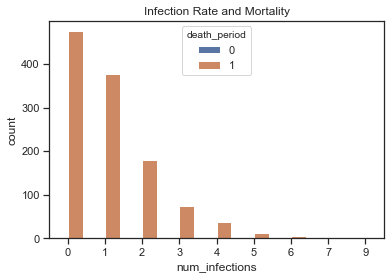

In [389]:
ax = plt.axes()
sns.countplot(x="num_infections", hue="death_period", data=multi_bio, ax=ax)
ax.set_title('Infection Rate and Mortality')

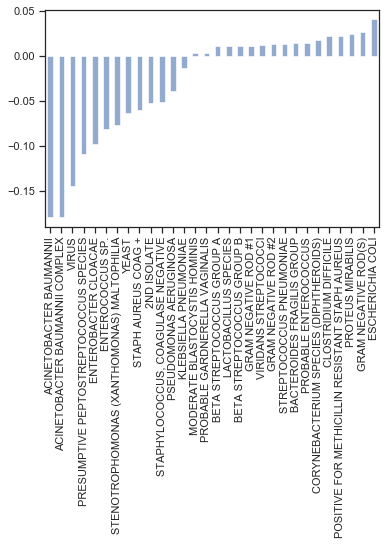

In [386]:
correlation_df = multi_bio.corr().copy()
plt.rcParams.update({'font.size': 2})
tst = correlation_df['death_period']
tst = tst[mlb.classes_]
tst.sort_values(inplace=True)
tst_condensed = tst[:15]
tst_condensed = tst_condensed.append( tst[-15:])
tst_condensed.plot(kind='bar', alpha=0.6)

As can be seen here, the number and type of infections are not strongly correlated with the survivability of sepsis. This could be due to a number of reasons. Due to the lack of usefulness in predicting survivability of a septic condition, it is worth considering removing them altogether or reducing the dimensionality of the data to aid in the machine learning phase.

## Feature Selection
Considering the previous sections including visualizations into the correlation between certain vitals and survivability as well as bio lab test results and suvivability, it is time to trim features that are of little use in predicting survivability. 

### Test With All Features
Let us see how well Adaptive boosting does with a decision stump base estimator and compare the result when we trim all bio information out.

In [387]:
y_all = multi_bio['death_period']
X_all = multi_bio.drop(['death_period', 'subject_id', 'hadm_id', 'admittime', 'ethnicity', 'dob'], 1)
X_all = pd.get_dummies(X_all)

In [409]:
# X_all_new=np.array(X_all['num_infections']).reshape(1,-1)
# X_all_new = stdsc.fit_transform(X_all_new)
#X_all['num_infections'] = stdsc.fit_transform(np.array(X_all['num_infections']).reshape(1,-1))
X_all['num_infections'] = stdsc.fit_transform(np.array(X_all['num_infections']).reshape(-1,1)).reshape(1,-1)[0]

In [411]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
#from sklearn.grid_search import RandomizedSearchCV

stump_clf =  DecisionTreeClassifier(random_state=42, max_depth=1)

param_grid = {
              "base_estimator__max_features": ['auto', 'sqrt', 'log2'],
              "n_estimators": list(range(1,500)),
              "learning_rate": np.linspace(0.01, 1, num=20),
             }

ada_clf = AdaBoostClassifier(base_estimator = stump_clf)

rand_ada = RandomizedSearchCV(ada_clf, param_grid, scoring = 'accuracy', n_iter=100, random_state=42)
#y_all=np.array(y_all).reshape(1,-1)
rand_ada.fit(X_all,y_all)

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                                base_estimator=DecisionTreeClassifier(class_weight=None,
                                                                                      criterion='gini',
                                                                                      max_depth=1,
                                                                                      max_features=None,
                                                                                      max_leaf_nodes=None,
                                                                                      min_impurity_decrease=0.0,
                                                                                      min_impurity_split=None,
                                                                                      min_samples_leaf=1,
                  

In [412]:
print(rand_ada.best_score_)
print(rand_ada.best_params_)
print(rand_ada.best_estimator_)

0.987331081081081
{'n_estimators': 278, 'learning_rate': 0.6352631578947369, 'base_estimator__max_features': 'auto'}
AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features='auto',
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         p

While a prediction accuracy of .812 is not bad for an initial pass, let us check the result when we trim all of this information out.

In [413]:
y_vitals = vital_patient_info['death_period']
X_vitals = vital_patient_info.drop(['death_period', 'subject_id', 'hadm_id', 'admittime', 'ethnicity', 'dob'], 1)
X_vitals = pd.get_dummies(X_vitals)

In [414]:
rand_ada = RandomizedSearchCV(ada_clf, param_grid, scoring = 'accuracy', n_iter=100, random_state=42)
rand_ada.fit(X_vitals,y_vitals)

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                                base_estimator=DecisionTreeClassifier(class_weight=None,
                                                                                      criterion='gini',
                                                                                      max_depth=1,
                                                                                      max_features=None,
                                                                                      max_leaf_nodes=None,
                                                                                      min_impurity_decrease=0.0,
                                                                                      min_impurity_split=None,
                                                                                      min_samples_leaf=1,
                  

In [58]:
print(rand_ada.best_score_)
print(rand_ada.best_params_)
print(rand_ada.best_estimator_)

0.834459459459
{'n_estimators': 327, 'learning_rate': 0.06210526315789474, 'base_estimator__max_features': 'sqrt'}
AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=0.06210526315789474, n_estimators=327,
          random_state=None)


We increased predictive accuracy marginally. Infection type does not tend to indicate survivability so in order to reduce features, it will be likely be trimmed in the model building phase.

### Assessing Feature Importance with Random Forests

In [103]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
              "n_estimators": list(range(1,1000)),
             }

forest = RandomForestClassifier( random_state=42)

In [112]:
rand_for = RandomizedSearchCV(forest, param_grid, scoring = 'accuracy', n_iter=20, random_state=42)
_ = rand_for.fit(X_vitals,y_all)

In [113]:
print(rand_for.best_score_)
print(rand_for.best_params_)
print(rand_for.best_estimator_)

0.830236486486
{'n_estimators': 861}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=861, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)


In [114]:
importances = rand_for.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_vitals.shape[1]):
    print "{}) {} {}".format(f, X_vitals.columns[indices[f]], importances[indices[f]])

0) lactate 0.0969784268579
1) PH 0.0894660825308
2) bicarbonate 0.0659836132261
3) BUN 0.0632510173184
4) PT 0.0523806586957
5) RBCDW 0.0514374895954
6) calcium 0.0473450099908
7) AST 0.045504428118
8) platelet 0.0429429886793
9) MCH 0.0411469514548
10) age 0.0408527767491
11) hematocrit 0.0406661817607
12) glucose 0.0401809772364
13) creatinine 0.0395509272337
14) alkaline phosphatase 0.0392265237408
15) neutrophils 0.0381829697316
16) PTT 0.0370072172162
17) hemoglobin 0.0360834340481
18) INR 0.0357253979273
19) lymphocytes 0.035523907528
20) gender_M 0.00441401541385
21) gender_F 0.00433165466973
22) insurance_Private 0.00406179007861
23) insurance_Medicare 0.00392657865536
24) insurance_Medicaid 0.00198844442361
25) insurance_Government 0.000609728531941
26) admission_type_URGENT 0.000440954856568
27) admission_type_EMERGENCY 0.000405981957336
28) insurance_Self Pay 0.000383871773803


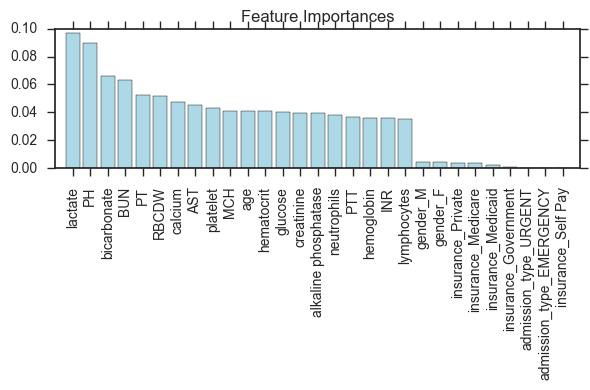

In [116]:
plt.title('Feature Importances')
plt.bar(range(X_vitals.shape[1]), importances[indices], color='lightblue', align='center')
plt.xticks(range(X_vitals.shape[1]), X_vitals.columns[indices], rotation=90)
plt.xlim([-1, X_vitals.shape[1]])
plt.tight_layout()

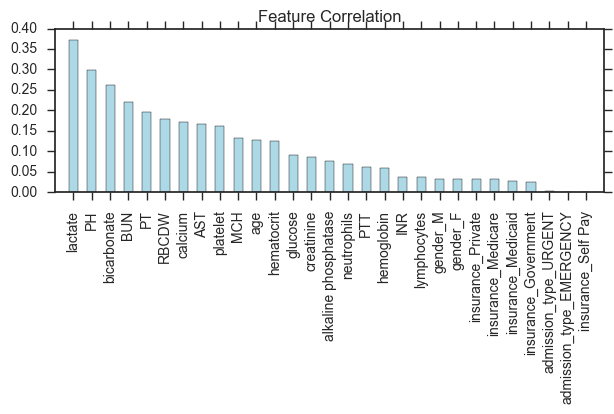

In [70]:
result = pd.concat([X_vitals, y_all], axis=1, join_axes=[X_vitals.index])
plt.title('Feature Correlation')
tst =  result.corr().copy()['death_period'].abs()
tst = tst.drop('death_period')
tst.sort_values(inplace=True, ascending=False)
tst.plot(kind='bar', color='lightblue', align='center')
plt.xticks(range(X_vitals.shape[1]), X_vitals.columns[indices], rotation=90)
plt.xlim([-1, X_vitals.shape[1]])
plt.tight_layout()

So we can see that there are some correlations between the feature correlation to patient survival and the feature importance provided by the random forest. The insurance type, gender and admission type just do not play a significant enough role to leave in our feature set. They will likely be trimmed.

We now have a clear idea of how to pre-process the data, and what features really matter in predicting the survivability. The random forest already had a very high accuracy rate so it will be important to ensure overfitting is not occuring and improving the results further with other algorithms and techniques. 

In the next notebook, models will be trained and tested and compared for accuracy.